# 神经网络：感知机Perceptron

感知机Perceptron是一种**人工神经元**。   
在现代的神经网络工作中，更常用的是另一种人工神经元--**sigmoid神经元**。

## Udacity：
![title](../images/perceptron_u.png)

图解：   
激活函数activation function： $${\sum_{i=1}^k}x_i \cdot w_i$$
阈值firing threshold：$\theta$
符号函数sign function：$$sign(x) = \begin{cases} +1, & x \ge 0 \\ 0, & x < 0 \end{cases}$$

在图中的例子$x_1 = 1, x_2 = 0, x_3 = -1.5$，$w_1 = 1/2, w_2 = 3/5, w_3 = 1$，
求得的结果为-1，-1小于0，所以$y = 0$。

#### 感知器得出的都是线性关系，所有的感知器都将计算线性问题，始终都将计算半平面halfplanes。
感知器就是一个线性函数，它计算的是超平面。

NAND门（与非门）可以用来做基本逻辑运算。   
事实上，我们可以使用感知机网络做任何逻辑运算。   
因为**与非门**是通用的计算，我们可以用与非门实现任何运算。

<a href = 'https://www.jianshu.com/p/921e9c6be305'>与非门示例</a>

### Perceptron Trainging:
Given examples, find weights that map inputs to outputs.
- perceptron rule   (threshold)
- gradient descent / delta rule ( unthreshold)

## perceptron rule (threshold)
![title](../images/Perceptron_rule.png)



## gradient descent / delta rule ( unthreshold)
![title](../images/Gradient_descent.png)

#### 上图理解：
- 第一张图，Perceptron Rule，我们仅针对$y-\hat y$

### 自定义感知机训练模型示例

感知机模型只有$w$和$b$两个参数，其中$w$是一个n维向量（$w \in R^n$），$b$是一个标量（$b \in R$）。   
为了保证收敛性，我们需要将$w$初始化为零向量，将$b$初始化为0。

<a href = 'https://www.leiphone.com/news/201706/QFydbeV7FXQtRIOl.html'>来源</a>

In [54]:
import numpy as np
class Perceptron:
    '''
    自定义感知机训练模型
    
    '''
    def __init__(self):
        self._w = None
        self._b = None
    
    def fit(self, x, y, lr=0.01, epoch=1000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        self._w = np.zeros(x.shape[1])
        self._b = 0 
        
        for _ in range(epoch):
            y_pred = x.dot(self._w) + self._b  # 计算 w·x+b
            idx = np.argmax(np.maximum(0, -y_pred * y))  # 求所有y_true和y_pred的结果不一致的y的索引列表
           
            if y[idx] * y_pred[idx] > 0:
                break
            delta = lr * y[idx]
            self._w += delta * w[idx]
            self._b += delta
        print(self._w)
        print(self._b)

perceptron_obj = Perceptron()
X_train = [[1,1], [2,2], [3,3], [4,4]]
y_train = [[0], [0], [1], [1]]
perceptron_obj.fit(X_train, y_train)        

[0. 0.]
[0.]


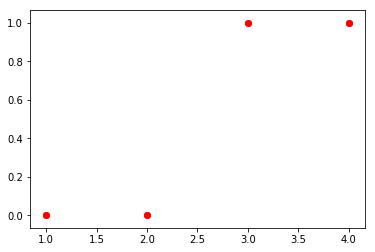

**梯度下降法**：
- 第一步：求损失函数的梯度（求导）
- 第二步：梯度是函数值增长最快的方向，我们想要最小化损失函数，想要让函数值减小得最快，就是将参数沿着梯度的反方向走一步。

## 李航：
感知机（perceptron）是二类分类的线性分类模型，其输入为实例的特征向量，输出为实例的类别，取 +1 和 -1 二值。   
感知机对应于输入空间（特征空间）中将实例划分为正负两类的分离超平面，属于判别模型。   
感知机学习旨在求出将训练数据进行线性划分的分离超平面，为此，导入基于误分类的损失函数，利用梯度下降法对损失函数进行极小化，求得感知机模型。   
感知机学习算法具有简单而易于实现的优点，分为原始形式和对偶形式。    
感知机预测是用学习得到的感知机模型对新的输入实例进行分类。  
感知机1957年由Rosenblatt提出，是神经网络与支持向量机的基础。 

### 感知机模型
感知机定义：   
假设输入空间（特征空间）$X \subseteq R^{n}$，输出空间是$y =\{+1, -1\}$。输入$x\in{X}$表示实例的特征向量，对应于输入空间（特征空间）的点；输出$y\in Y$表示实例的类别。   
由输入空间到输出空间的函数：
$$f(x) = sign(w\cdot x +b)$$ 称为感知机。   

其中，$w$和$b$为感知机模型参数，$w\in R^{n}$叫做权值（weight）或权值向量(weight vector)，$b\in R$叫做偏置(bias)，     
$w \cdot x$表示$w$和$x$的内积。    
sign是符号函数，即$$sign(x) = \begin{cases} +1, & x \ge 0 \\ -1, & x < 0 \end{cases}$$


感知机是一种线性分类模型，属于判别模型。   
感知机模型的假设空间是定义在特征空间中的所有线性分类模型（linear classification model）或线性分类器（linear classifier），即函数集合$\{ f | f(x) = w \cdot x + b\}$。


感知机的几何解释：  
线性方程：$$w \cdot x + b = 0$$
对应于特征空间$R^{n}$中的一个超平面$S$，其中$w$是超平面的法向量，$b$是超平面的截距。 这个超平面将特征空间划分为两个部分。   
位于两部分的点（特征向量）分别被分为正、负两类。   
因此，超平面$S$称为分离超平面(separating hyperplane)。

![title](../images/perceptron_model1.png)


感知机学习，由训练数据集（实例的特征向量及类别）  
$$ T = \{(x_1，y_1), (x_2, y_2), ... , (x_N, y_N)\}$$   
其中，$x_i \in X = R^n$，$y_i \in Y = \{+1, -1\}$，$i = 1,2,...,N$，求得感知机模型，即求得模型参数$w$，$b$。   
感知机预测，通过学习得到的感知机模型，对于新年的输入实例给出其对应的输出类别。

### 感知机的学习策略（损失函数）
#### 1.数据集的线性可分性：
给定一个数据集$$T=\{(x_1, y_1), (x_2, y_2), ... , (x_N, y_N)\}$$
其中，$x_i \in X = R^n$, $y_i in Y = \{+1, -1\}$, $i = 1,2,...,N$,  如果存在某个超平面$S$
$$w \cdot x + b = 0$$
能够将数据集的正实例点和负实例点完全正确地划分到超平面的两侧，即对所有$y_i = +1 $的实例$i$，有$w \cdot x_i + b > 0$，对所有$y_i = -1$的实例$i$，有$w \cdot x_i + b < 0$，则称数据集$T$为线性可分数据集（linear separable data set）；否则，称数据集$T$线性不可分。


#### 2.感知机学习策略
假设训练数据集是线性可分的，感知机学习的目标是求得一个能够将训练集正实例点和负实例点完全正确分开的分离超平面。    
为了找出这样的超平面，即确定感知机模型参数$w$，$b$，需要确定一个学习策略，即**定义（经验）损失函数并将损失函数最小化。**      

**损失函数：**
- 损失函数的一个自然选择是误分类点的总数。   
    - 但是，这样的损失函数不是参数$w$，$b$的连续可导函数，不易优化。    
- 损失函数的另一个选择是误分类点到超平面$S$的总距离，这是感知机所采用的。
    - 为此，首先写出输入空间$R^n$中任一点$x_0$到超平面$S$的距离：
        $$\frac{1}{||w||}|w \cdot x_0 + b |$$
        这里，$||w||$是$w$的$L_2$范数。
    - 其次，对于误分类的数据$(x_i, y_i)$来说：
        $$-y_i(w \cdot x_i + b ) > 0$$
    - 这样，假设超平面$S$的误分类点的集合为$M$，那么所有误分类点到超平面$S$的总距离为
        $$- \frac{1}{||w||} \sum_{x_i \in M} y_i(w \cdot x_i + b)$$
    - 不考虑$- \frac{1}{||w||}$，就得到感知机学习的损失函数。
    
由上可得，给定训练数据集
$$ T = \{(x_1, y_1), (x_2, y_2), ... , (x_N, y_N)\}$$
其中，$x_i \in X = R^n$，$y_i \in Y = \{ +1, -1\}$，$i = 1,2,...,N$。感知机$sign(w \cdot x + b)$学习的损失函数定义为
$$L(w, b) = -\sum_{x_i \in M} y_i(w \cdot x_i + b)$$

### 感知机学习算法：原始形式、对偶形式
### 算法的收敛性